In [1]:
import pandas as pd
driver_id = pd.read_csv(r"C:\Users\cangr\Downloads\driver_ids.csv")
ride_ts = pd.read_csv(r"C:\Users\cangr\Downloads\ride_timestamps.csv")
ride_id = pd.read_csv(r"C:\Users\cangr\Downloads\ride_ids.csv")

In [2]:
ride_ts_dict={}
for counter,elem in enumerate(ride_ts['ride_id']):
    if elem not in ride_ts_dict:
        ride_ts_dict[elem] = ride_ts['ride_picked_up_at'][counter]
    else:
        print('Error')

driver_id_dict={}
for counter,elem in enumerate(driver_id['driver_id']):
    if elem not in driver_id_dict:
        driver_id_dict[elem] = driver_id['driver_onboard_date'][counter]
    else:
        print('Error')

In [3]:
import time
import datetime
# find the last timestamp
last_ts,first_ts=0,float('inf')
for counter,elem in enumerate(ride_ts['ride_picked_up_at']):
    last_ts = max(last_ts,
                  time.mktime(datetime.datetime.strptime(elem, "%Y-%m-%d %H:%M:%S").timetuple()))
    first_ts = min(first_ts,
                  time.mktime(datetime.datetime.strptime(elem, "%Y-%m-%d %H:%M:%S").timetuple()))   
print('total range:',(last_ts-first_ts)/3600.0/24.0)

total range: 90.74961805555556


In [478]:
# ride_id

In [336]:
driver_ride_id_dict={}
unknown_ride_ide_count, unknown_driver_ide_count=0, 0
for counter,elem in enumerate(ride_id['driver_id']):
    if ride_id['ride_id'][counter] not in ride_ts_dict:
#         print('Unkown ride_id (no mapping between driver_id and ride_id)')
        unknown_ride_ide_count+=1
        continue
        
    if elem not in driver_id_dict:
        unknown_driver_ide_count+=1
        continue
    
    onboard_time = time.mktime(datetime.datetime.strptime(driver_id_dict[elem], "%Y-%m-%d %H:%M:%S").timetuple())
    thisride_time= time.mktime(datetime.datetime.strptime(ride_ts_dict[ride_id['ride_id'][counter]], "%Y-%m-%d %H:%M:%S").timetuple())
    time_range = float(format((thisride_time-onboard_time)/3600.0/24.0,'.2f'))
    vacum_to_date = float(format((last_ts-thisride_time)/3600.0/24.0,'.2f'))
    time_to_onboard_range = float(format((thisride_time-onboard_time)/3600.0/24.0,'.2f'))
    
    if elem not in driver_ride_id_dict:
        driver_ride_id_dict[elem]=[[ride_id['ride_id'][counter],ride_id['ride_distance'][counter],
                            ride_id['ride_duration'][counter],ride_id['ride_prime_time'][counter],
                            time_to_onboard_range,time_range,vacum_to_date]]
    else:
        driver_ride_id_dict[elem].append([ride_id['ride_id'][counter],ride_id['ride_distance'][counter],
                                  ride_id['ride_duration'][counter],ride_id['ride_prime_time'][counter],
                                  time_to_onboard_range,time_range,vacum_to_date])

# driver_ride_id_dict，
# 0: ride_id 1: this_ride_distance 2:this_ride_duration 3: this_ride_prime_time  4: this_ride_time_to_onboard
# 5: same as 4   6: didn't_drive_time_to_last_date

In [337]:
# one week time range
A=time.mktime(datetime.datetime.strptime('2016-05-04 00:00:00', "%Y-%m-%d %H:%M:%S").timetuple())
B=time.mktime(datetime.datetime.strptime('2016-05-11 00:00:00', "%Y-%m-%d %H:%M:%S").timetuple())
one_week_time_range = B-A

In [760]:
# driver_ride_id_dict，
# 0: ride_id 1: this_ride_distance 2:this_ride_duration 3: this_ride_prime_time  4: this_ride_time_to_onboard
# 5: same as 4   6: didn't_drive_time_to_last_date

driver_freq_dict={} #drive freqent and last time
for elem in driver_ride_id_dict.keys():
    driver_freq_dict[elem]=[]
    max_range,last_to_date,first_time_range = 0,float('inf'),float('inf')
    ride_distance_sum, ride_duration_sum = 0, 0
    count_one_week, duration_time,distance_time = 0, 0, 0
    prime_time_sum = 0
    for counter,items in enumerate(driver_ride_id_dict[elem]):
        last_to_date = min(last_to_date,items[6])
        max_range = max(max_range,items[5])
        first_time_range = min(first_time_range,items[4])
        ride_duration_sum += items[2]
        ride_distance_sum += items[1]
        prime_time_sum += items[3]
        
        if items[2] <= one_week_time_range:
            count_one_week += 1        
            duration_time += items[2]
            distance_time += items[1] 
            
    driver_freq_dict[elem]=[counter,0,
                            float(format(counter/max_range,'.2f')),last_to_date,
                            first_time_range, float(format(ride_duration_sum/counter/3600.0,'.2f')), 
                            float(format(ride_distance_sum/counter/1000.0,'.2f')),duration_time/3600.0/24.0,count_one_week,
                            distance_time/count_one_week/1000.0,
                            float(format(prime_time_sum/counter,'.2f'))]

#[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# 4:vacum time from on board, 5:mean time per costumer (hour), 6:mean distance per customer (km), 7:duration_time_within_first_week,
# 8: number_of_rides_in_first_week, 9:distance_time_within_first_week, 10:prime_prob]

In [761]:
# driver_freq_dict

In [762]:
# # first week drive time and duration
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline
# duration_list,counts_list=[],[]
# for elem in driver_freq_dict.keys():
#     duration_list.append(driver_freq_dict[elem][7]/3600.0/24.0)
#     counts_list.append(driver_freq_dict[elem][8])
# duration_list = sorted(duration_list)
# x = np.linspace(0, len(duration_list), len(duration_list), endpoint=True)
# plt.plot(duration_list,x)

In [764]:
#[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer]

# method 1: 取最后一次的记录到截至日期的间隔
# driver_freq_dict
ratios = 1
churn_ratio=[]
for ratio in range(ratios,89,1):
    crit_item_index = 3
    sum_churn_freq,sum_unchurn_freq = 0,0
    count_churn,count_unchurn = 0,0
    driver_churn_dict, driver_unchurn_dict = {}, {}
    for elem in driver_freq_dict.keys():
        if driver_freq_dict[elem][crit_item_index]<ratio:
            driver_churn_dict[elem]=driver_freq_dict[elem]
            sum_churn_freq = driver_churn_dict[elem][crit_item_index]+sum_churn_freq
            count_churn+=1
        else:
            driver_unchurn_dict[elem]=driver_freq_dict[elem]
            sum_unchurn_freq = driver_unchurn_dict[elem][crit_item_index]+sum_unchurn_freq
            count_unchurn+=1
#     print(ratio)
#     print(count_churn, count_unchurn)
#     print(sum_churn_freq/count_churn, sum_unchurn_freq/count_unchurn)
#     print((sum_churn_freq/count_churn)/(sum_unchurn_freq/count_unchurn))
#     churn_ratio.append((sum_churn_freq/count_churn)/(sum_unchurn_freq/count_unchurn))
#     print('----------------------------')

In [759]:
# import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib inline
# plt.figure(figsize=(20,10))
# axes= plt.axes()
# axes.set_xticks(np.linspace(ratios, 89, len(churn_ratio), endpoint=False))
# axes.plot(np.linspace(ratios, 89, len(churn_ratio), endpoint=False),churn_ratio,'-*')

# # pick 50, because it has the largest gradient

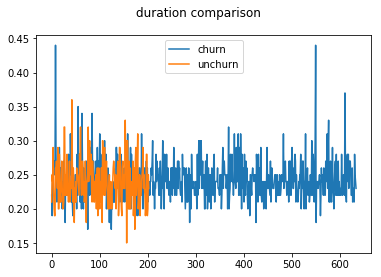

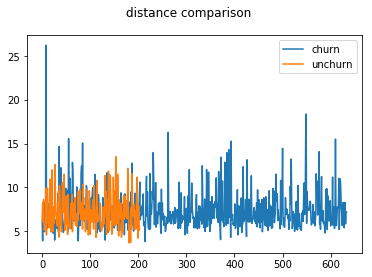

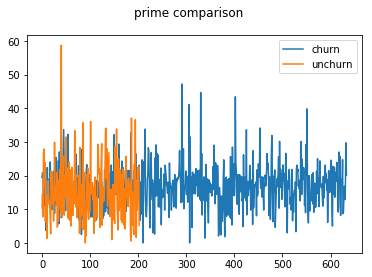

churn duration mean:0.2427287066246057,std:0.029538493773642358
unchurn duration mean:0.239064039408867,std:0.033522447995988705
----------------------------------
churn distance mean:7.32916403785489,std:2.2042461378401152
unchurn distance mean:7.230837438423646,std:1.9615161493384667
----------------------------------
churn prime mean:16.808880126182967,std:6.256055477207284
unchurn prime mean:15.088472906403942,std:8.53236660803994


In [765]:
#[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer, 7:duration_time_within_first_week,
# 8: number_of_rides_in_first_week, 9:prime_time_prob]
ratio = 21
# churn_ratio=[]
# for ratio in range(ratio,90,5):
crit_item_index = 3
sum_churn_freq,sum_unchurn_freq = 0,0
count_churn,count_unchurn = 0,0
driver_churn_dict, driver_unchurn_dict = {}, {}
churn_index,unchurn_index,churn_prime_prob,unchurn_prime_prob=[],[],[],[]
for counter,elem in enumerate(driver_freq_dict.keys()):
    if driver_freq_dict[elem][crit_item_index]<ratio:
        driver_churn_dict[elem]=driver_freq_dict[elem]
        sum_churn_freq = driver_churn_dict[elem][crit_item_index]+sum_churn_freq
        count_churn+=1
        churn_index.append(counter)
    else:
        driver_unchurn_dict[elem]=driver_freq_dict[elem]
        sum_unchurn_freq = driver_unchurn_dict[elem][crit_item_index]+sum_unchurn_freq
        count_unchurn+=1
        unchurn_index.append(counter)

# insight
churn_distant_list,churn_duration_list,unchurn_distant_list,unchurn_duration_list=[],[],[],[]
for elem in driver_churn_dict.keys():
    churn_duration_list.append(driver_churn_dict[elem][5])
    churn_distant_list.append(driver_churn_dict[elem][6])
    churn_prime_prob.append(driver_churn_dict[elem][10])
    
for elem in driver_unchurn_dict.keys():
    unchurn_duration_list.append(driver_unchurn_dict[elem][5])
    unchurn_distant_list.append(driver_unchurn_dict[elem][6])
    unchurn_prime_prob.append(driver_unchurn_dict[elem][10])
    
fig = plt.figure()
plt.plot(churn_duration_list,label='churn')
plt.plot(unchurn_duration_list,label='unchurn')
fig.suptitle('duration comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(churn_distant_list,label='churn')
plt.plot(unchurn_distant_list,label='unchurn')
fig.suptitle('distance comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(churn_prime_prob,label='churn')
plt.plot(unchurn_prime_prob,label='unchurn')
fig.suptitle('prime comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
plt.legend()
plt.show()

print('churn duration mean:{},std:{}'.format(np.mean(churn_duration_list),np.std(churn_duration_list)))
print('unchurn duration mean:{},std:{}'.format(np.mean(unchurn_duration_list),np.std(unchurn_duration_list)))
print('----------------------------------')
print('churn distance mean:{},std:{}'.format(np.mean(churn_distant_list),np.std(churn_distant_list)))
print('unchurn distance mean:{},std:{}'.format(np.mean(unchurn_distant_list),np.std(unchurn_distant_list)))
print('----------------------------------')
print('churn prime mean:{},std:{}'.format(np.mean(churn_prime_prob),np.std(churn_prime_prob)))
print('unchurn prime mean:{},std:{}'.format(np.mean(unchurn_prime_prob),np.std(unchurn_prime_prob)))

In [766]:
# #[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# # 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer, 7:duration_time_within_first_week,
# # 8: number_of_rides_in_first_week, 9:prime_time_prob]
# # method 3: 取频率
# # driver_freq_dict
# ratios = 10
# crit_item_index = 1
# churn_ratio=[]

# for ratio in range(ratios,90,1):
# #     ratio = ratio/2.0
#     sum_churn_freq,sum_unchurn_freq = 0,0
#     count_churn,count_unchurn = 0,0
#     driver_churn_dict, driver_unchurn_dict = {}, {}
#     for elem in driver_freq_dict.keys():
#         if driver_freq_dict[elem][crit_item_index]<ratio:
#             driver_churn_dict[elem]=driver_freq_dict[elem]
#             sum_churn_freq = driver_churn_dict[elem][crit_item_index]+sum_churn_freq
#             count_churn+=1
#         else:
#             driver_unchurn_dict[elem]=driver_freq_dict[elem]
#             sum_unchurn_freq = driver_unchurn_dict[elem][crit_item_index]+sum_unchurn_freq
#             count_unchurn+=1
#     print(ratio)
#     print(count_churn, count_unchurn)
#     print(sum_churn_freq/count_churn, sum_unchurn_freq/count_unchurn)
#     print((sum_churn_freq/count_churn)/(sum_unchurn_freq/count_unchurn))
#     churn_ratio.append((sum_churn_freq/count_churn)/(sum_unchurn_freq/count_unchurn))
#     print('----------------------------')

In [587]:
# plt.figure(figsize=(20,10))
# # plt.plot(churn_ratio)
# axes= plt.axes()
# axes.set_xticks(np.linspace(ratios, 90, len(churn_ratio), endpoint=False))
# axes.plot(np.linspace(ratios, 90, len(churn_ratio), endpoint=False),churn_ratio,'-*')

In [588]:
# #[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# # 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer, 7:duration_time_within_first_week,
# # 8: number_of_rides_in_first_week, 9:prime_time_prob]

# ratio = 30
# crit_item_index = 1
# sum_churn_freq,sum_unchurn_freq = 0,0
# count_churn,count_unchurn = 0,0
# driver_churn_dict, driver_unchurn_dict = {}, {}
# for elem in driver_freq_dict.keys():
#     if driver_freq_dict[elem][crit_item_index]<ratio:
#         driver_churn_dict[elem]=driver_freq_dict[elem]
#         sum_churn_freq = driver_churn_dict[elem][crit_item_index]+sum_churn_freq
#         count_churn+=1
#     else:
#         driver_unchurn_dict[elem]=driver_freq_dict[elem]
#         sum_unchurn_freq = driver_unchurn_dict[elem][crit_item_index]+sum_unchurn_freq
#         count_unchurn+=1

# # insight
# churn_distant_list,churn_duration_list,unchurn_distant_list,unchurn_duration_list=[],[],[],[]
# churn_prime_prob,unchurn_prime_prob = [],[]
# for elem in driver_churn_dict.keys():
#     churn_duration_list.append(driver_churn_dict[elem][5])
#     churn_distant_list.append(driver_churn_dict[elem][6])
#     churn_prime_prob.append(driver_churn_dict[elem][10])
# for elem in driver_unchurn_dict.keys():
#     unchurn_duration_list.append(driver_unchurn_dict[elem][5])
#     unchurn_distant_list.append(driver_unchurn_dict[elem][6])
#     unchurn_prime_prob.append(driver_unchurn_dict[elem][10])


    
# fig = plt.figure()
# plt.plot(churn_duration_list,label='churn')
# plt.plot(unchurn_duration_list,label='unchurn')
# fig.suptitle('duration comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
# plt.legend()
# plt.show()

# fig = plt.figure()
# plt.plot(churn_distant_list,label='churn')
# plt.plot(unchurn_distant_list,label='unchurn')
# fig.suptitle('distance comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
# plt.legend()
# plt.show()

# fig = plt.figure()
# plt.plot(churn_prime_prob,label='churn')
# plt.plot(unchurn_prime_prob,label='unchurn')
# fig.suptitle('prime comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
# plt.legend()
# plt.show()

# print('churn duration mean:{},std:{}'.format(np.mean(churn_duration_list),np.std(churn_duration_list)))
# print('unchurn duration mean:{},std:{}'.format(np.mean(unchurn_duration_list),np.std(unchurn_duration_list)))
# print('----------------------------------')
# print('churn distance mean:{},std:{}'.format(np.mean(churn_distant_list),np.std(churn_distant_list)))
# print('unchurn distance mean:{},std:{}'.format(np.mean(unchurn_distant_list),np.std(unchurn_distant_list)))
# print('----------------------------------')
# print('churn prime mean:{},std:{}'.format(np.mean(churn_prime_prob),np.std(churn_prime_prob)))
# print('unchurn prime mean:{},std:{}'.format(np.mean(unchurn_prime_prob),np.std(unchurn_prime_prob)))

In [589]:
# driver_freq_dict

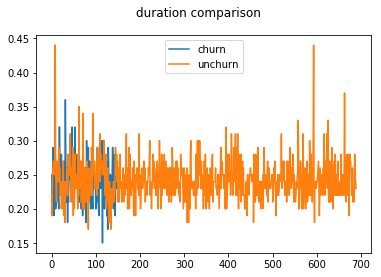

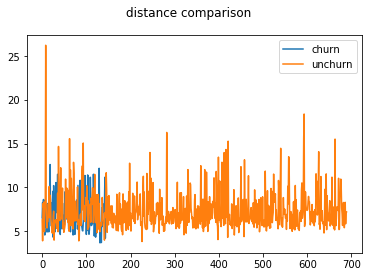

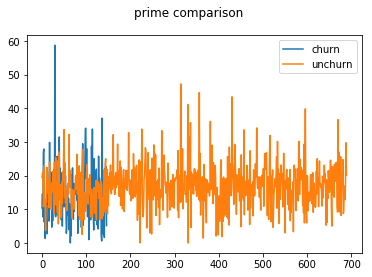

churn duration mean:0.23877551020408158,std:0.03396472678465143
unchurn duration mean:0.2424927536231884,std:0.02978455157808179
----------------------------------
churn distance mean:7.1532653061224485,std:1.9298585346149773
unchurn distance mean:7.337710144927537,std:2.190675953530175
----------------------------------
churn prime mean:14.102448979591836,std:8.560286694276847
unchurn prime mean:16.879318840579714,std:6.4088968934672605


In [767]:
# combine method 1 and method 2
#[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer, 7:duration_time_within_first_week,
# 8: number_of_rides_in_first_week, 9:prime_time_prob]

ratio_whole_range, ratio_last_range = 47, 30
crit_item_index_whole_range, crit_item_index_last_range = 1, 3
sum_churn_whole_range,sum_unchurn_whole_range = 0,0
sum_churn_last_range,sum_unchurn_last_range = 0,0
count_churn,count_unchurn = 0,0

driver_churn_dict, driver_unchurn_dict = {}, {}
churn_index,unchurn_index=[],[]
Y=[]
for counter,elem in enumerate(driver_freq_dict.keys()):
    if driver_freq_dict[elem][crit_item_index_whole_range]<ratio_whole_range and driver_freq_dict[elem][crit_item_index_last_range]>ratio_last_range:
        driver_churn_dict[elem]=driver_freq_dict[elem]
        sum_churn_whole_range = driver_churn_dict[elem][crit_item_index_whole_range]+sum_churn_whole_range
        sum_churn_last_range  = driver_churn_dict[elem][crit_item_index_last_range]+sum_churn_last_range
        count_churn+=1
        churn_index.append(counter)
        Y.append(1)
    else:
        driver_unchurn_dict[elem]=driver_freq_dict[elem]
        sum_unchurn_whole_range = driver_unchurn_dict[elem][crit_item_index_whole_range]+sum_unchurn_whole_range
        sum_unchurn_last_range = driver_unchurn_dict[elem][crit_item_index_last_range]+sum_unchurn_last_range
        count_unchurn+=1
        unchurn_index.append(counter)
        Y.append(0)
    driver_freq_dict[elem][crit_item_index_last_range]=0
    driver_freq_dict[elem][crit_item_index_whole_range]=0
# insight
churn_distant_list,churn_duration_list,unchurn_distant_list,unchurn_duration_list=[],[],[],[]
churn_prime_prob,unchurn_prime_prob = [],[]
for elem in driver_churn_dict.keys():
    churn_duration_list.append(driver_churn_dict[elem][5])
    churn_distant_list.append(driver_churn_dict[elem][6])
    churn_prime_prob.append(driver_churn_dict[elem][10])
for elem in driver_unchurn_dict.keys():
    unchurn_duration_list.append(driver_unchurn_dict[elem][5])
    unchurn_distant_list.append(driver_unchurn_dict[elem][6])
    unchurn_prime_prob.append(driver_unchurn_dict[elem][10])


    
fig = plt.figure()
plt.plot(churn_duration_list,label='churn')
plt.plot(unchurn_duration_list,label='unchurn')
fig.suptitle('duration comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(churn_distant_list,label='churn')
plt.plot(unchurn_distant_list,label='unchurn')
fig.suptitle('distance comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(churn_prime_prob,label='churn')
plt.plot(unchurn_prime_prob,label='unchurn')
fig.suptitle('prime comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
plt.legend()
plt.show()

print('churn duration mean:{},std:{}'.format(np.mean(churn_duration_list),np.std(churn_duration_list)))
print('unchurn duration mean:{},std:{}'.format(np.mean(unchurn_duration_list),np.std(unchurn_duration_list)))
print('----------------------------------')
print('churn distance mean:{},std:{}'.format(np.mean(churn_distant_list),np.std(churn_distant_list)))
print('unchurn distance mean:{},std:{}'.format(np.mean(unchurn_distant_list),np.std(unchurn_distant_list)))
print('----------------------------------')
print('churn prime mean:{},std:{}'.format(np.mean(churn_prime_prob),np.std(churn_prime_prob)))
print('unchurn prime mean:{},std:{}'.format(np.mean(unchurn_prime_prob),np.std(unchurn_prime_prob)))

In [597]:
import numpy as np
from sklearn.manifold import TSNE
X = []
for elem in driver_freq_dict.keys():
    X.append(driver_freq_dict[elem])
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(837, 2)

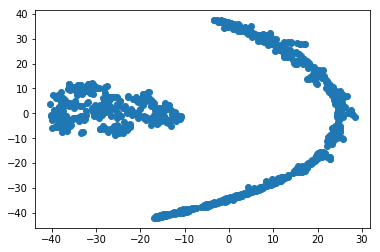

In [598]:
plt.scatter(X_embedded[:,0],X_embedded[:,1])

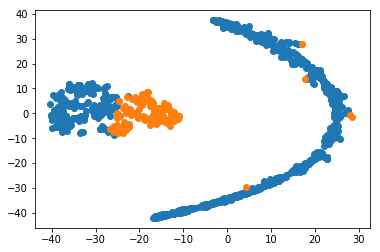

In [599]:
plt.scatter(X_embedded[unchurn_index][:,0],X_embedded[unchurn_index][:,1])
plt.scatter(X_embedded[churn_index][:,0],X_embedded[churn_index][:,1])
# plt.scatter(X_embedded[unchurn_index][:,0],X_embedded[unchurn_index][:,1])


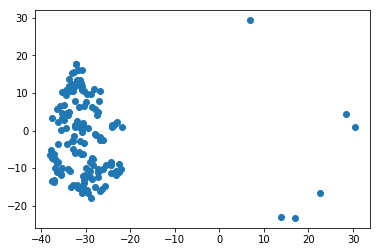

In [565]:
# plt.scatter(X_embedded[unchurn_index][:,0],X_embedded[unchurn_index][:,1])
plt.scatter(X_embedded[churn_index][:,0],X_embedded[churn_index][:,1])
# plt.scatter(X_embedded[unchurn_index][:,0],X_embedded[unchurn_index][:,1])


In [603]:
X_test,Y_test = [],[]
X_train,Y_train=[],[]
cumulate_index_churn=0
cumulate_index_unchurn=0
for counter,i in enumerate(Y):
    if i == 1 and cumulate_index_churn<=9:
        cumulate_index_churn += 1
        X_test.append(X[counter])
        Y_test.append(Y[counter])
    elif i == 0 and cumulate_index_unchurn<=9:
        cumulate_index_unchurn += 1
        X_test.append(X[counter])
        Y_test.append(Y[counter])        
    else:
        X_train.append(X[counter])
        Y_train.append(Y[counter])
print(sum(Y_train),sum(Y_test))        

137 10


In [604]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(X_train, Y_train)
error=sum(abs(clf.predict(X_test)-np.array(Y_test)))/len(Y_test)
error

0.05

In [605]:
sum(clf.predict(X))

143

In [606]:
clf.feature_importances_
#[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer, 7:duration_time_within_first_week,
# 8: number_of_rides_in_first_week, 9:distance_time_within_first_week, 10:prime_prob]

array([0.01783693, 0.        , 0.41709322, 0.        , 0.01281981,
       0.04181935, 0.03478352, 0.317155  , 0.04721763, 0.04409361,
       0.06718092])

In [172]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=2)
# clustering = DBSCAN(eps=3, min_samples=2).fit(X)
# # kmeans.fit(X)
# y_kmeans = kmeans .predict(X)

# X_1,X_0=[],[]
# for counter,i in enumerate(y_kmeans):
#     if i == 1:
#         X_1.append(list(X_embedded[counter]))
#     else:
#         X_0.append(list(X_embedded[counter]))
# X_1 = np.array(X_1)
# X_0 = np.array(X_0)
# plt.scatter(X_1[:,0],X_1[:,1])
# plt.scatter(X_0[:,0],X_0[:,1])

In [753]:
# Double
# driver_ride_id_dict，
# 0: ride_id 1: this_ride_distance 2:this_ride_duration 3: this_ride_prime_time  4: this_ride_time_to_onboard
# 5: same as 4   6: didn't_drive_time_to_last_date

times_ratio=1
driver_freq_dict_double={} #drive freqent and last time
for elem in driver_ride_id_dict.keys():
    driver_freq_dict_double[elem]=[]
    max_range,last_to_date,first_time_range = 0,float('inf'),float('inf')
    ride_distance_sum, ride_duration_sum = 0, 0
    count_one_week, duration_time,distance_time = 0, 0, 0
    prime_time_sum = 0
    for counter,items in enumerate(driver_ride_id_dict[elem]):
        last_to_date = min(last_to_date,items[6])
        max_range = max(max_range,items[5])
        first_time_range = min(first_time_range,items[4])
        ride_duration_sum += items[2]
        ride_distance_sum += items[1]
        prime_time_sum += items[3]
        
        if items[2] <= one_week_time_range:
            count_one_week += times_ratio        
            duration_time += items[2]*times_ratio
            distance_time += items[1]*times_ratio
            ride_duration_sum += items[2]*(times_ratio-1)
            ride_distance_sum += items[1]*(times_ratio-1)  
            
    driver_freq_dict_double[elem]=[counter,0,
                            float(format(counter/max_range,'.2f')),0,
                            first_time_range, float(format(ride_duration_sum/counter/3600.0,'.2f')), 
                            float(format(ride_distance_sum/counter/1000.0,'.2f')),duration_time/3600.0/24.0,count_one_week,
                            distance_time/count_one_week/1000.0,
                            float(format(prime_time_sum/counter,'.2f'))*1.75]
    
    driver_freq_dict_double[elem][crit_item_index_last_range]=0
    driver_freq_dict_double[elem][crit_item_index_whole_range]=0
#[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer, 7:duration_time_within_first_week,
# 8: number_of_rides_in_first_week, 9:distance_time_within_first_week, 10:prime_prob]

In [754]:
# driver_freq_dict_double

In [755]:
X_double = []
for elem in driver_freq_dict_double.keys():
    X_double.append(driver_freq_dict_double[elem])

In [756]:
Y_double=clf.predict(X_double)
# X_1,X_0=[],[]
# for counter,i in enumerate(Y_double):
#     if i == 1:
#         X_1.append(X_double[counter])
#     else:
#         X_0.append(X_double[counter])
# X_1 = np.array(X_1)
# X_0 = np.array(X_0)

In [758]:
abs(sum(Y_double))-sum(Y)

-5

In [740]:
sum(abs(Y_double-Y))

86

In [362]:
import numpy as np
from sklearn.manifold import TSNE
X = []
for elem in driver_freq_dict.keys():
    X.append(driver_freq_dict[elem])
X_embedded_double = TSNE(n_components=2).fit_transform(X)
X_embedded_double.shape

(837, 2)

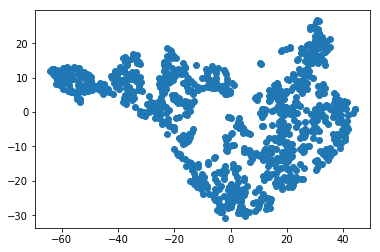

In [334]:
plt.scatter(X_embedded_double[:,0],X_embedded_double[:,1])

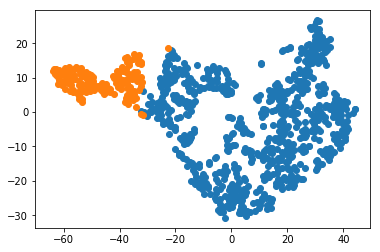

In [335]:
plt.scatter(X_embedded_double[unchurn_index][:,0],X_embedded_double[unchurn_index][:,1])
plt.scatter(X_embedded_double[churn_index][:,0],X_embedded_double[churn_index][:,1])


In [186]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [205]:
sum(y_kmeans)

392

In [193]:
X_1,X_0=[],[]
for counter,i in enumerate(y_kmeans):
    if i == 1:
        X_1.append(list(X_embedded[counter]))
    else:
        X_0.append(list(X_embedded[counter]))
X_1 = np.array(X_1)
X_0 = np.array(X_0)

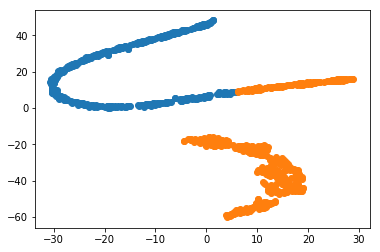

In [196]:
plt.scatter(X_1[:,0],X_1[:,1])
plt.scatter(X_0[:,0],X_0[:,1])

In [102]:
# #[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# # 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer, 7:duration_time_within_first_week,
# # 8: number_of_rides_in_first_week, 9:prime_time_prob]
# # method 2: 取次数
# # driver_freq_dict
# ratio = 50
# crit_item_index = 0
# churn_ratio=[]

# for ratio in range(ratio,150,10):
#     sum_churn_freq,sum_unchurn_freq = 0,0
#     count_churn,count_unchurn = 0,0
#     driver_churn_dict, driver_unchurn_dict = {}, {}
#     for elem in driver_freq_dict.keys():
#         if driver_freq_dict[elem][crit_item_index]<ratio:
#             driver_churn_dict[elem]=driver_freq_dict[elem]
#             sum_churn_freq = driver_churn_dict[elem][crit_item_index]+sum_churn_freq
#             count_churn+=1
#         else:
#             driver_unchurn_dict[elem]=driver_freq_dict[elem]
#             sum_unchurn_freq = driver_unchurn_dict[elem][crit_item_index]+sum_unchurn_freq
#             count_unchurn+=1
#     print(ratio)
#     print(count_churn, count_unchurn)
#     print(sum_churn_freq/count_churn, sum_unchurn_freq/count_unchurn)
#     print((sum_churn_freq/count_churn)/(sum_unchurn_freq/count_unchurn))
#     churn_ratio.append((sum_churn_freq/count_churn)/(sum_unchurn_freq/count_unchurn))
#     print('----------------------------')

In [103]:
# #[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# # 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer, 7:duration_time_within_first_week,
# # 8: number_of_rides_in_first_week, 9:prime_time_prob]

# ratio = 90
# crit_item_index = 0
# sum_churn_freq,sum_unchurn_freq = 0,0
# count_churn,count_unchurn = 0,0
# driver_churn_dict, driver_unchurn_dict = {}, {}
# for elem in driver_freq_dict.keys():
#     if driver_freq_dict[elem][crit_item_index]<ratio:
#         driver_churn_dict[elem]=driver_freq_dict[elem]
#         sum_churn_freq = driver_churn_dict[elem][crit_item_index]+sum_churn_freq
#         count_churn+=1
#     else:
#         driver_unchurn_dict[elem]=driver_freq_dict[elem]
#         sum_unchurn_freq = driver_unchurn_dict[elem][crit_item_index]+sum_unchurn_freq
#         count_unchurn+=1

# # insight
# churn_distant_list,churn_duration_list,unchurn_distant_list,unchurn_duration_list=[],[],[],[]
# churn_prime_prob,unchurn_prime_prob = [],[]
# for elem in driver_churn_dict.keys():
#     churn_duration_list.append(driver_churn_dict[elem][5])
#     churn_distant_list.append(driver_churn_dict[elem][6])
#     churn_prime_prob.append(driver_churn_dict[elem][9])
# for elem in driver_unchurn_dict.keys():
#     unchurn_duration_list.append(driver_unchurn_dict[elem][5])
#     unchurn_distant_list.append(driver_unchurn_dict[elem][6])
#     unchurn_prime_prob.append(driver_unchurn_dict[elem][9])


    
# fig = plt.figure()
# plt.plot(churn_duration_list,label='churn')
# plt.plot(unchurn_duration_list,label='unchurn')
# fig.suptitle('duration comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
# plt.legend()
# plt.show()

# fig = plt.figure()
# plt.plot(churn_distant_list,label='churn')
# plt.plot(unchurn_distant_list,label='unchurn')
# fig.suptitle('distance comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
# plt.legend()
# plt.show()

# fig = plt.figure()
# plt.plot(churn_prime_prob,label='churn')
# plt.plot(unchurn_prime_prob,label='unchurn')
# fig.suptitle('prime comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
# plt.legend()
# plt.show()

In [104]:
# #[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# # 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer, 7:duration_time_within_first_week,
# # 8: number_of_rides_in_first_week, 9:prime_time_prob]
# # method 3: 取频率
# # driver_freq_dict
# ratios = 1
# crit_item_index = 2
# churn_ratio=[]

# for ratio in range(ratios,16,1):
#     ratio = ratio/2.0
#     sum_churn_freq,sum_unchurn_freq = 0,0
#     count_churn,count_unchurn = 0,0
#     driver_churn_dict, driver_unchurn_dict = {}, {}
#     for elem in driver_freq_dict.keys():
#         if driver_freq_dict[elem][crit_item_index]<ratio:
#             driver_churn_dict[elem]=driver_freq_dict[elem]
#             sum_churn_freq = driver_churn_dict[elem][crit_item_index]+sum_churn_freq
#             count_churn+=1
#         else:
#             driver_unchurn_dict[elem]=driver_freq_dict[elem]
#             sum_unchurn_freq = driver_unchurn_dict[elem][crit_item_index]+sum_unchurn_freq
#             count_unchurn+=1
#     print(ratio)
#     print(count_churn, count_unchurn)
#     print(sum_churn_freq/count_churn, sum_unchurn_freq/count_unchurn)
#     print((sum_churn_freq/count_churn)/(sum_unchurn_freq/count_unchurn))
#     churn_ratio.append((sum_churn_freq/count_churn)/(sum_unchurn_freq/count_unchurn))
#     print('----------------------------')

In [105]:
# plt.plot(churn_ratio)

In [106]:
# #[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# # 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer, 7:duration_time_within_first_week,
# # 8: number_of_rides_in_first_week, 9:prime_time_prob]

# ratio = 2.5
# crit_item_index = 2
# sum_churn_freq,sum_unchurn_freq = 0,0
# count_churn,count_unchurn = 0,0
# driver_churn_dict, driver_unchurn_dict = {}, {}
# for elem in driver_freq_dict.keys():
#     if driver_freq_dict[elem][crit_item_index]<ratio:
#         driver_churn_dict[elem]=driver_freq_dict[elem]
#         sum_churn_freq = driver_churn_dict[elem][crit_item_index]+sum_churn_freq
#         count_churn+=1
#     else:
#         driver_unchurn_dict[elem]=driver_freq_dict[elem]
#         sum_unchurn_freq = driver_unchurn_dict[elem][crit_item_index]+sum_unchurn_freq
#         count_unchurn+=1

# # insight
# churn_distant_list,churn_duration_list,unchurn_distant_list,unchurn_duration_list=[],[],[],[]
# churn_prime_prob,unchurn_prime_prob = [],[]
# for elem in driver_churn_dict.keys():
#     churn_duration_list.append(driver_churn_dict[elem][5])
#     churn_distant_list.append(driver_churn_dict[elem][6])
#     churn_prime_prob.append(driver_churn_dict[elem][9])
# for elem in driver_unchurn_dict.keys():
#     unchurn_duration_list.append(driver_unchurn_dict[elem][5])
#     unchurn_distant_list.append(driver_unchurn_dict[elem][6])
#     unchurn_prime_prob.append(driver_unchurn_dict[elem][9])


    
# fig = plt.figure()
# plt.plot(churn_duration_list,label='churn')
# plt.plot(unchurn_duration_list,label='unchurn')
# fig.suptitle('duration comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
# plt.legend()
# plt.show()

# fig = plt.figure()
# plt.plot(churn_distant_list,label='churn')
# plt.plot(unchurn_distant_list,label='unchurn')
# fig.suptitle('distance comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
# plt.legend()
# plt.show()

# fig = plt.figure()
# plt.plot(churn_prime_prob,label='churn')
# plt.plot(unchurn_prime_prob,label='unchurn')
# fig.suptitle('prime comparison', fontdict={'fontsize': 8, 'fontweight': 'medium'})
# plt.legend()
# plt.show()